# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import ( 
RareLabelEncoder,
MeanEncoder,
CountFrequencyEncoder
)

import matplotlib.pyplot as plt
import warnings

# 2. Display Settings

In [4]:
pd.set_option('display.max_columns',None)

In [5]:
sklearn.set_config(transform_output='pandas')

In [7]:
warnings.filterwarnings('ignore')

# 3. Read Data

In [12]:
file_path= file_path = r'/Users/dilli/Machine Learning Project/flight_sagemaker/data/train.csv'
train=pd.read_csv(file_path,keep_default_na=False)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,No Info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,No Info,10975
3,Indigo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,No Info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,No Info,5678
...,...,...,...,...,...,...,...,...,...,...
6689,Spicejet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,435,1,No Info,8479
6690,Multiple Carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,930,1,No Info,15078
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,1180,2,No Info,8603
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,330,1,No Info,8759


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          6694 non-null   object
 1   date_of_journey  6694 non-null   object
 2   source           6694 non-null   object
 3   destination      6694 non-null   object
 4   dep_time         6694 non-null   object
 5   arrival_time     6694 non-null   object
 6   duration         6694 non-null   int64 
 7   total_stops      6694 non-null   int64 
 8   additional_info  6694 non-null   object
 9   price            6694 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 523.1+ KB


In [16]:
X_train = train.drop(columns='price')
y_train=train.price.copy()

In [18]:
X_train.shape

(6694, 9)

In [20]:
y_train.shape

(6694,)

# 4. Transformation

#### 4.1 `airlines`

In [26]:
air_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
    ('ohe',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
]
)

air_transformer.fit_transform(X_train.loc[:,['airline']])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0
6690,0.0,0.0,0.0,1.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,0.0,0.0,1.0


#### 4.2 `date_of_journey`

In [29]:
train.date_of_journey

0       2019-05-27
1       2019-06-12
2       2019-05-18
3       2019-06-03
4       2019-04-01
           ...    
6689    2019-06-09
6690    2019-05-09
6691    2019-05-18
6692    2019-05-18
6693    2019-04-09
Name: date_of_journey, Length: 6694, dtype: object

In [31]:
features_to_extract=['month','week','day_of_week','day_of_year']
doj_transformers=Pipeline(
    steps=[
        ('dt',DatetimeFeatures(features_to_extract=features_to_extract)),
        ('scaler',MinMaxScaler())
    ]
)

doj_transformers.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.764706,0.000000,0.737288
1,1.000000,0.882353,0.333333,0.872881
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.823529,0.000000,0.796610
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
6689,1.000000,0.823529,1.000000,0.847458
6690,0.666667,0.588235,0.500000,0.584746
6691,0.666667,0.647059,0.833333,0.661017
6692,0.666667,0.647059,0.833333,0.661017


#### 4.3 `source` and `destination`

In [34]:
location_subset = X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Mumbai,Hyderabad
4,Mumbai,Hyderabad
...,...,...
6689,Kolkata,Banglore
6690,Delhi,Cochin
6691,Delhi,Cochin
6692,Delhi,Cochin


In [36]:
location_pipe1 = Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
    ('encoder',MeanEncoder()),
    ('scaler',PowerTransformer()) 
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.040187,1.039963
1,-0.190314,-0.185612
2,1.040187,1.039963
3,-1.915733,-0.892199
4,-1.915733,-0.892199
...,...,...
6689,-0.190314,-0.185612
6690,1.040187,1.039963
6691,1.040187,1.039963
6692,1.040187,1.039963


In [38]:
np.union1d(X_train.source,X_train.destination)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [40]:
def is_north(X):
    columns=X.columns
    north_cities=['Delhi','Kolkata','Mumbai','New Delhi']
    return(
        X.assign(**{
            f'{col}_is_north':X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
            
        })
        .drop(columns=columns)
    )
    

In [42]:
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6689,1,0
6690,1,0
6691,1,0
6692,1,0


In [44]:
location_transformer = FeatureUnion(transformer_list=[
    ('part1',location_pipe1),
    ('part2',FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.040187,1.039963,1,0
1,-0.190314,-0.185612,1,0
2,1.040187,1.039963,1,0
3,-1.915733,-0.892199,1,0
4,-1.915733,-0.892199,1,0
...,...,...,...,...
6689,-0.190314,-0.185612,1,0
6690,1.040187,1.039963,1,0
6691,1.040187,1.039963,1,0
6692,1.040187,1.039963,1,0


#### 4.4 `dep_time` and `arrival_time`

In [47]:
time_subset=X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,20:55:00,12:35:00
1,18:55:00,16:20:00
2,09:45:00,09:25:00
3,21:20:00,22:50:00
4,02:55:00,04:20:00
...,...,...
6689,11:35:00,18:50:00
6690,10:00:00,01:30:00
6691,12:00:00,07:40:00
6692,07:55:00,13:25:00


In [49]:
time_pipe1 = Pipeline(
    steps=[
        ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
        ('scaler',MinMaxScaler())
    ]
)
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,1.000000,0.521739,0.636364
1,0.782609,1.000000,0.695652,0.363636
2,0.391304,0.818182,0.391304,0.454545
3,0.913043,0.363636,0.956522,0.909091
4,0.086957,1.000000,0.173913,0.363636
...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091
6690,0.434783,0.000000,0.043478,0.545455
6691,0.521739,0.000000,0.304348,0.727273
6692,0.304348,1.000000,0.565217,0.454545


In [51]:
def part_of_day(X,morning=4,noon=12,eve=16,night=20):
    columns=X.columns.to_list()
    X_temp=X.assign(**{
        col:pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return(
        X_temp.assign(**{
            f'{col}_part_of_day':np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive='left'),
                 X_temp.loc[:,col].between(noon,eve,inclusive='left'),
                 X_temp.loc[:,col].between(eve,night,inclusive='left')],
                 ['morning','afternoon','evening'],
                 default= 'night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,afternoon
1,evening,evening
2,morning,morning
3,night,night
4,night,morning
...,...,...
6689,morning,evening
6690,morning,night
6691,afternoon,morning
6692,morning,afternoon


In [53]:
time_pipe2=Pipeline(steps=[
    ('part',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.159827,0.000000
1,0.195680,0.699256
2,1.000000,0.968119
3,0.159827,1.000000
4,0.159827,0.968119
...,...,...
6689,1.000000,0.699256
6690,1.000000,1.000000
6691,0.000000,0.968119
6692,1.000000,0.000000


In [55]:
time_transformer=FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('part2',time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000
1,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256
2,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119
3,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000
4,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119
...,...,...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256
6690,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000
6691,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119
6692,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


#### 4.5 `duration`

In [64]:
X_train.duration

0        940
1       1285
2       1420
3         90
4         85
        ... 
6689     435
6690     930
6691    1180
6692     330
6693     660
Name: duration, Length: 6694, dtype: int64

In [66]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [68]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train.loc[:,['duration']])

,duration_rbf_40,duration_rbf_80
0,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00
...,...,...
6689,1.569292e-213,0.000000e+00
6690,0.000000e+00,0.000000e+00
6691,0.000000e+00,1.125982e-278
6692,6.293989e-54,0.000000e+00


In [70]:
def duration_category(X,short=180,med=400):
    return(
        X.assign(duration_cat = np.select([X.duration.lt(short),
                                          X.duration.between(short,med,inclusive='left')],
                                         ["short",'medium'],
                                         default = 'long'))
        .drop(columns='duration')
    )

In [72]:
def is_over(X, value=1000):
    return (
        X
        .assign(**{
            f'duration_over_{value}':X.duration.ge(value).astype(int)
        })
        .drop(columns='duration')
    )

In [74]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.353152,-0.119075,-0.099367,2.0,0,0.609935
1,-0.353152,-0.119075,-0.099368,2.0,1,1.301752
2,-0.353152,-0.119075,-0.099368,2.0,1,1.572463
3,-0.353152,-0.119075,-0.099368,0.0,0,-1.094542
4,-0.353152,-0.119075,-0.099368,0.0,0,-1.104568
...,...,...,...,...,...,...
6689,-0.353152,-0.119075,-0.099368,2.0,0,-0.402725
6690,-0.353152,-0.119075,10.098457,2.0,0,0.589882
6691,-0.353152,-0.119075,-0.099368,2.0,1,1.091199
6692,-0.353152,-0.119075,-0.099368,1.0,0,-0.613278


In [76]:
duration_pipe1=Pipeline(steps=[
    ('rbf',RBFPercentileSimilarity()),
    ('scaler',PowerTransformer())
])

duration_pipe2=Pipeline(steps=[
    ('cat',FunctionTransformer(func=duration_category)),
    ('encoder', OrdinalEncoder(categories=[['short','medium','long']]))
])

duration_union = FeatureUnion(transformer_list=[
    ('part1',duration_pipe1),
    ('part2',duration_pipe2),
    ('part3',FunctionTransformer(func=is_over)),
    ('part4',StandardScaler())
])

duration_transformer =Pipeline(steps = [
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('imputer',SimpleImputer(strategy='median')),
    ('union', duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.353152,-0.119075,-0.099367,2.0,0,0.609935
1,-0.353152,-0.119075,-0.099368,2.0,1,1.301752
2,-0.353152,-0.119075,-0.099368,2.0,1,1.572463
3,-0.353152,-0.119075,-0.099368,0.0,0,-1.094542
4,-0.353152,-0.119075,-0.099368,0.0,0,-1.104568
...,...,...,...,...,...,...
6689,-0.353152,-0.119075,-0.099368,2.0,0,-0.402725
6690,-0.353152,-0.119075,10.098457,2.0,0,0.589882
6691,-0.353152,-0.119075,-0.099368,2.0,1,1.091199
6692,-0.353152,-0.119075,-0.099368,1.0,0,-0.613278


#### 4.6. `total_stops`

In [79]:
train.total_stops

0       1
1       1
2       2
3       0
4       0
       ..
6689    1
6690    1
6691    2
6692    1
6693    1
Name: total_stops, Length: 6694, dtype: int64

In [81]:
def is_direct(X):
    return (
        X.assign(is_direct_flight = X.total_stops.eq(0).astype(int))
    )

total_stops_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer()),
    ('direct',FunctionTransformer(func=is_direct))
])
total_stops_transformer.fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,2.0,0
3,0.0,1
4,0.0,1
...,...,...
6689,1.0,0
6690,1.0,0
6691,2.0,0
6692,1.0,0


#### 4.7. `additional_info`

In [85]:
info_pipe1=Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1, n_categories=2,replace_with = 'Other')),
    ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))  
])

info_pipe1.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6689,0.0,1.0,0.0
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,0.0,1.0,0.0


In [87]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne('No Info').astype(int))

In [89]:
info_union=FeatureUnion(transformer_list=[
    ('part1',info_pipe1),
    ('part2', FunctionTransformer(func=have_info))
])

info_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='unknown')),
    ('union',info_union)
])

info_transformer.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6689,0.0,1.0,0.0,0
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,0.0,1.0,0.0,0


In [91]:
train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info',
 'price']

#### 4.8. `Columns Transformers`

In [93]:
col_transformer= ColumnTransformer(transformers=[
    ('air',air_transformer,['airline']),
    ('journey',doj_transformers,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('duration',duration_transformer,['duration']),
    ("stops", total_stops_transformer, ["total_stops"]),
    ('info',info_transformer,['additional_info'])
],
    remainder='passthrough'
)
col_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,journey__date_of_journey_month,journey__date_of_journey_week,journey__date_of_journey_day_of_week,journey__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,duration__duration_rbf_25,duration__duration_rbf_50,duration__duration_rbf_75,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.040187,1.039963,1,0,0.869565,1.000000,0.521739,0.636364,0.159827,0.000000,-0.353152,-0.119075,-0.099367,2.0,0,0.609935,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.190314,-0.185612,1,0,0.782609,1.000000,0.695652,0.363636,0.195680,0.699256,-0.353152,-0.119075,-0.099368,2.0,1,1.301752,1.0,0,0.0,1.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.391304,0.818182,0.391304,0.454545,1.000000,0.968119,-0.353152,-0.119075,-0.099368,2.0,1,1.572463,2.0,0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-1.915733,-0.892199,1,0,0.913043,0.363636,0.956522,0.909091,0.159827,1.000000,-0.353152,-0.119075,-0.099368,0.0,0,-1.094542,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,-1.915733,-0.892199,1,0,0.086957,1.000000,0.173913,0.363636,0.159827,0.968119,-0.353152,-0.119075,-0.099368,0.0,0,-1.104568,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,1.000000,0.847458,-0.190314,-0.185612,1,0,0.478261,0.636364,0.782609,0.909091,1.000000,0.699256,-0.353152,-0.119075,-0.099368,2.0,0,-0.402725,1.0,0,0.0,1.0,0.0,0
6690,0.0,0.0,0.0,1.0,0.0,0.666667,0.588235,0.500000,0.584746,1.040187,1.039963,1,0,0.434783,0.000000,0.043478,0.545455,1.000000,1.000000,-0.353152,-0.119075,10.098457,2.0,0,0.589882,1.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.521739,0.000000,0.304348,0.727273,0.000000,0.968119,-0.353152,-0.119075,-0.099368,2.0,1,1.091199,2.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,1.040187,1.039963,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.353152,-0.119075,-0.099368,1.0,0,-0.613278,1.0,0,0.0,1.0,0.0,0


# 5. Feature Selection

In [100]:
estimator = RandomForestRegressor(n_estimators = 10,max_depth =3)
selector =SelectBySingleFeaturePerformance(estimator=estimator,scoring='r2',threshold=0.1)

preprocessor= Pipeline(steps = [
    ('ct',col_transformer),
    ('features',selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,journey__date_of_journey_week,journey__date_of_journey_day_of_year,location__source,location__destination,duration__duration_rbf_25,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.764706,0.737288,1.040187,1.039963,-0.353152,2.0,0,0.609935,1.0,0
1,0.0,1.0,0.0,0.882353,0.872881,-0.190314,-0.185612,-0.353152,2.0,1,1.301752,1.0,0
2,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.039963,-0.353152,2.0,1,1.572463,2.0,0
3,1.0,0.0,0.0,0.823529,0.796610,-1.915733,-0.892199,-0.353152,0.0,0,-1.094542,0.0,1
4,0.0,1.0,0.0,0.294118,0.262712,-1.915733,-0.892199,-0.353152,0.0,0,-1.104568,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.0,0.0,1.0,0.823529,0.847458,-0.190314,-0.185612,-0.353152,2.0,0,-0.402725,1.0,0
6690,0.0,0.0,0.0,0.588235,0.584746,1.040187,1.039963,-0.353152,2.0,0,0.589882,1.0,0
6691,0.0,0.0,0.0,0.647059,0.661017,1.040187,1.039963,-0.353152,2.0,1,1.091199,2.0,0
6692,0.0,0.0,1.0,0.647059,0.661017,1.040187,1.039963,-0.353152,1.0,0,-0.613278,1.0,0


# Visulations

In [125]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='other',
                                                                                    tol=0.1)),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('journey',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x131182e80>))]))]),
                                                  ['additional_info'])])),
                ('features',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [109]:
feature_performance=preprocessor.named_steps['features'].feature_performance_
feature_performance

{'air__airline_Air India': 0.001938307234533328,
 'air__airline_Indigo': 0.1250274542543476,
 'air__airline_Jet Airways': 0.18259093920515343,
 'air__airline_Multiple Carriers': 0.018594919688514122,
 'air__airline_other': 0.11311209948818486,
 'journey__date_of_journey_month': 0.08170667490330459,
 'journey__date_of_journey_week': 0.17075184930344253,
 'journey__date_of_journey_day_of_week': 0.0010570797495967899,
 'journey__date_of_journey_day_of_year': 0.21166339601326423,
 'location__source': 0.12625067442166707,
 'location__destination': 0.12182554121110171,
 'location__source_is_north': 0.02827786462622295,
 'location__destination_is_north': 0.028041541171677453,
 'time__dep_time_hour': 0.00982787341003577,
 'time__dep_time_minute': 0.031173214897985597,
 'time__arrival_time_hour': 0.06994413435054347,
 'time__arrival_time_minute': 0.03073082465122538,
 'time__dep_time_part_of_day': 2.185852634265887e-06,
 'time__arrival_time_part_of_day': 0.030259552572455273,
 'duration__durati

In [113]:
sorted_feature_performance = dict(sorted(feature_performance.items(), key=lambda item: item[1]))
sorted_feature_performance

{'duration__duration_rbf_75': -0.0008859523727526852,
 'info__additional_info_No Info': -0.0008747873119293222,
 'info__additional_info': -0.0005561672490028332,
 'time__dep_time_part_of_day': 2.185852634265887e-06,
 'journey__date_of_journey_day_of_week': 0.0010570797495967899,
 'info__additional_info_In-flight meal not included': 0.001678279839334514,
 'air__airline_Air India': 0.001938307234533328,
 'duration__duration_rbf_50': 0.004581348326222516,
 'time__dep_time_hour': 0.00982787341003577,
 'air__airline_Multiple Carriers': 0.018594919688514122,
 'info__additional_info_Other': 0.019303961326499735,
 'location__destination_is_north': 0.028041541171677453,
 'location__source_is_north': 0.02827786462622295,
 'time__arrival_time_part_of_day': 0.030259552572455273,
 'time__arrival_time_minute': 0.03073082465122538,
 'time__dep_time_minute': 0.031173214897985597,
 'time__arrival_time_hour': 0.06994413435054347,
 'journey__date_of_journey_month': 0.08170667490330459,
 'duration__durati

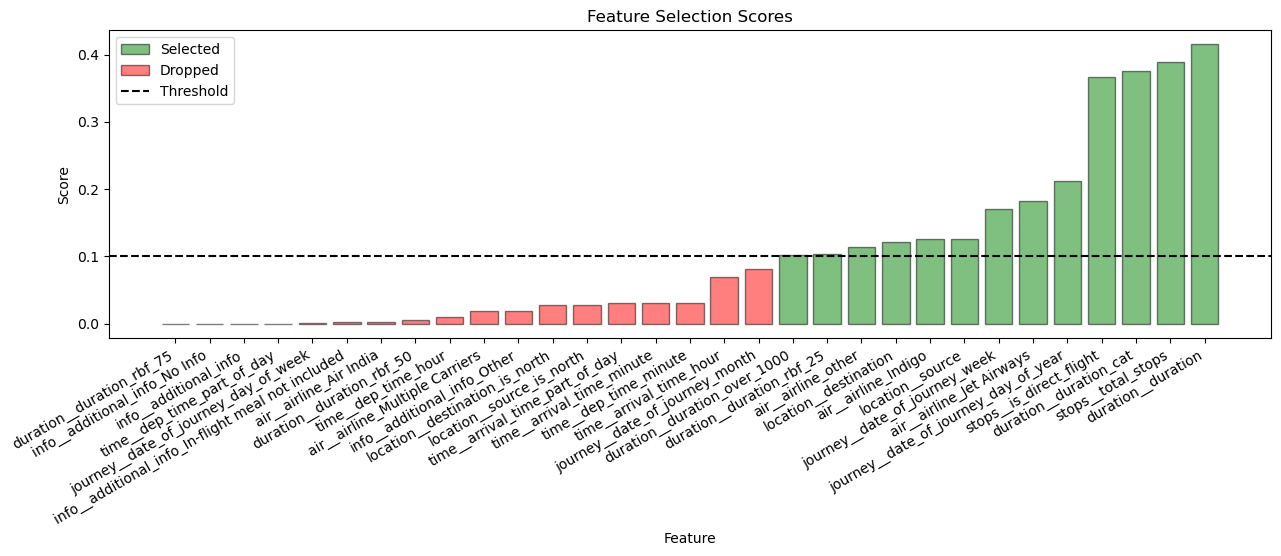

In [121]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feature_performance.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feature_performance.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feature_performance)),
	labels=list(sorted_feature_performance.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()